# Subarus in Seattle

This project is looking to determine if Seattle is the Subaru capital of the United States. In this analysis, we'll evaluate the data we collected.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pickle
import time
import os
import json
import seaborn as sns
import tensorflow as tf
import random
import cv2
from PIL import Image


from pandas import json_normalize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score,classification_report
from sklearn.preprocessing import normalize,StandardScaler,RobustScaler,MinMaxScaler
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.compose import ColumnTransformer
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import LabelBinarizer



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D,LeakyReLU
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from scipy.stats import skew
from scipy.sparse import csr_matrix

### Data Generator

In [2]:
image_dir = "Datasets/VMMRdb/"

In [3]:
def random_sample_images(image_dir, minority_class, sample_percent):
    class_images = {}
    for root, dirs, files in os.walk(image_dir):
        for filename in files:
            if not filename.startswith('.'):
                label = os.path.basename(root).split('_')[0]
                if label not in class_images:
                    class_images[label] = []
                filepath = os.path.join(root, filename)
                class_images[label].append(filepath)

    majority_classes = sorted(list(set(class_images.keys()) - {minority_class}))

    majority_class_images = []
    for cls in majority_classes:
        num_samples = int(len(class_images[cls]) * sample_percent)
        majority_class_images.extend(random.sample(class_images[cls], num_samples))

    minority_class_images = class_images[minority_class]

    images = majority_class_images + minority_class_images
    labels = [minority_class] * len(minority_class_images) + [cls for cls in majority_classes for i in range(num_samples)]

    return images, labels

In [4]:
images, labels = random_sample_images(image_dir, 'subaru', 0.2)

In [5]:
len(images)

62632

In [6]:
def image_data_generator(images, labels, batch_size):
    # Shuffle the images and labels
    combined = list(zip(images, labels))
    random.shuffle(combined)
    images, labels = zip(*combined)

    # Generate batches of data
    while True:
        for i in range(0, len(images), batch_size):
            batch_images = []
            batch_labels = []
            for j in range(i, min(i+batch_size, len(images))):
                filepath = images[j]
                label = labels[j]
                image = cv2.imread(filepath)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (224, 224))
                batch_images.append(image)
                batch_labels.append(label)
            yield np.array(batch_images), np.array(batch_labels)

In [7]:
generator = image_data_generator(images, labels, batch_size=32)

In [ ]:
all_images_list = []
all_labels_list = []

for batch_images, batch_labels in generator:
    all_images_list.append(batch_images)
    all_labels_list.append(batch_labels)

all_images = np.concatenate(all_images_list, axis=0)
all_labels = np.concatenate(all_labels_list, axis=0)

In [ ]:
X = all_images
y = all_labels

### Distribution of our Data

In [9]:
values, counts = np.unique(y, return_counts=True)

sorted_idx = np.argsort(counts)
values = values[sorted_idx]
counts = counts[sorted_idx]

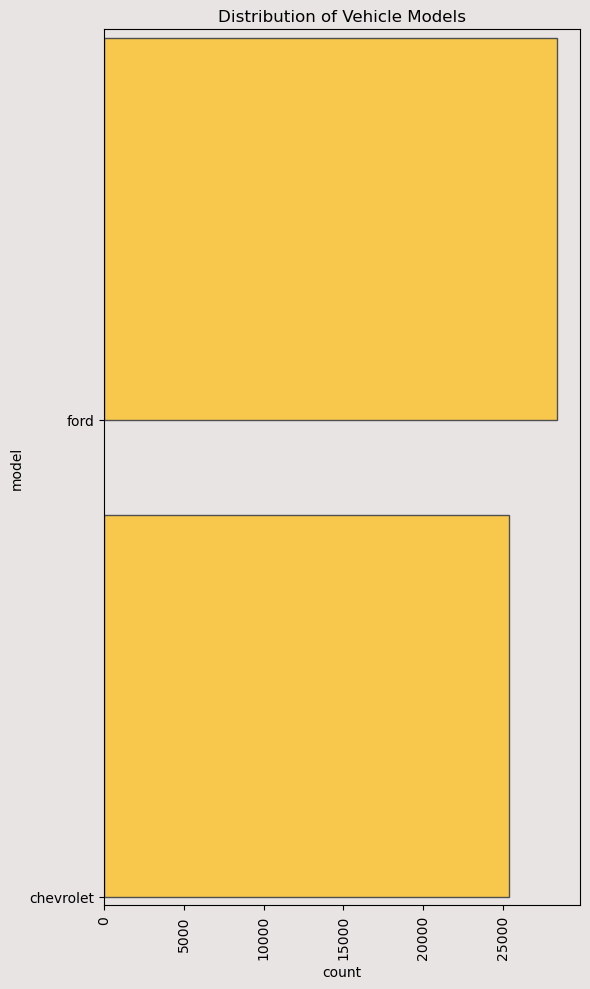

In [10]:
yellow = '#f8c84c'
grey = '#4F4F4F'
background = '#e8e4e4'

# Create the color map
colors = [grey, yellow]
cmap = LinearSegmentedColormap.from_list('my_palette', colors)

fig, ax = plt.subplots(figsize=(6, 10), facecolor=background)


# Plot the histogram with custom colors
ax.barh(values, counts, color=colors[1], edgecolor=grey, linewidth=1, align='edge')
ax.set_facecolor(background)

plt.title('Distribution of Vehicle Models')
plt.xlabel('count')
plt.ylabel('model')

# Rotate the x-axis labels by 90 degrees
plt.xticks(rotation=90)
plt.tight_layout()
plt.margins(y=.01, tight=True)

plt.show()

In [7]:
minority_label = 'subaru'
majority_labels = np.unique(y)[np.unique(y) != minority_label]

# Find the indices of the minority and majority class samples
minority_indices = np.where(y == minority_label)[0]
majority_indices = np.concatenate([np.where(y == label)[0] for label in majority_labels])

In [8]:
# Randomly sample from the majority class indices to balance the classes
num_samples = 150000
undersampled_majority_indices = np.random.choice(majority_indices, size=num_samples, replace=False)

In [9]:
# Combine the minority and undersampled majority class samples
undersampled_indices = np.concatenate((minority_indices, undersampled_majority_indices))

In [ ]:
X_undersampled = X[undersampled_indices]

In [ ]:
y_undersampled = y[undersampled_indices]

In [16]:
len(X_undersampled)

104982

In [18]:
values, counts = np.unique(y_undersampled, return_counts=True)

sorted_idx = np.argsort(counts)
values = values[sorted_idx]
counts = counts[sorted_idx]

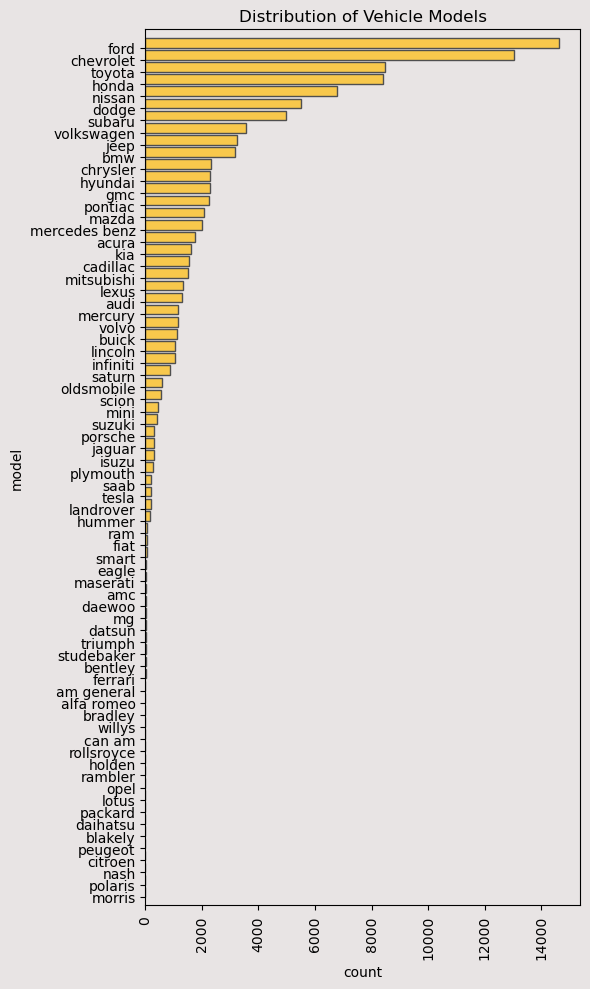

In [19]:
yellow = '#f8c84c'
grey = '#4F4F4F'
background = '#e8e4e4'

# Create the color map
colors = [grey, yellow]
cmap = LinearSegmentedColormap.from_list('my_palette', colors)

fig, ax = plt.subplots(figsize=(6, 10), facecolor=background)


# Plot the histogram with custom colors
ax.barh(values, counts, color=colors[1], edgecolor=grey, linewidth=1, align='edge')
ax.set_facecolor(background)

plt.title('Distribution of Vehicle Models')
plt.xlabel('count')
plt.ylabel('model')

# Rotate the x-axis labels by 90 degrees
plt.xticks(rotation=90)
plt.tight_layout()
plt.margins(y=.01, tight=True)

plt.show()

In [20]:
X = X_undersampled
y = y_undersampled

In [ ]:
with open('pickles/X.pkl', 'wb') as f:
    pickle.dump(X, f)

In [ ]:
with open('pickles/y.pkl', 'wb') as f:
    pickle.dump(y, f)